$$
\newcommand{\bx}{\boldsymbol{x}}
\newcommand{\bbeta}{\boldsymbol{\beta}}
\newcommand{\balpha}{\boldsymbol{\alpha}}
\newcommand{\btheta}{\boldsymbol{\theta}}
$$

# Ordinal regression using the threshold approach from scratch

Ordinal regression models are used when the outcome has $K$ ordered possible outcomes: $y \in [1,\dots,K]$, e.g. $y \in [\text{low},\text{mid},\text{high}]$. While the ordinal outcomes are discrete, the cumulative and probablility mass functions can be written for each level:

$$
\begin{align*}
P(y \leq k; \bx,\bbeta,\btheta  ) &= F(\theta_k - \bx^T \bbeta) \hspace{2mm} \longleftrightarrow \\
P(y = k ; \bx,\bbeta,\btheta) &= F(\theta_k - \bx^T \bbeta) - F(\theta_{k-1} - \bx^T \bbeta)
\end{align*}
$$

Different choices of $F$ are possible for the cumulative mass function including the standard normal CDF, but throughout this post we will use the sigmoid function: $F(z) = \sigma(z) = 1/(1+\exp(-z))$. Note that $\sigma'(z) = \sigma(z)(1-\sigma(z))$. For ordinal regression models using a "threshold" approach, there are $K+1$ intercepts of $[\theta_0,\theta_1,\dots,\theta_K]$, where $\theta_{k-1} < \theta_{k}$, $\forall k$. The bottom and top thresholds are fixed so that the CMF is bounded between $(0,1)$: $(\theta_0,\theta_K) = (-\infty,\infty)$ . When estimating the $K-1$ intercepts in $\btheta$ the inequality constraints must be preserved. Notice that each "level" of $y$ shares the same slope coefficients: $\bbeta$, and only differs in the intercepts. This is contrast to multinomial logistic regression where each $K-1$ class needs its own intercept and slope. This need is obviated due to the ordinal nature of the label and the assumption that the log-odds (when $F$ is the sigmoid anyways) changes in equal measure across all ordinal categories. For example if $\beta_1=2$, then a one-unit change in $x_1$ increases the log-odds that $y > 2, \dots, y>K-1$ by two.


 The log-likelihood and its gradient for $n$ samples can be written as:

$$
\begin{align*}
\log L(\bbeta) &= l(\bbeta;\btheta) = \sum_{i=1}^n I(y_i=k) \log  \big[ \sigma(\theta_k - \eta_i) - \sigma(\theta_{k-1} - \eta_i) \big] \\
\eta_i &= \bx_i^T \bbeta \\
\frac{\partial l(\bbeta;\btheta)}{\partial \bbeta} &= \nabla_\bbeta = -\sum_{i=1}^n \bx_i I(y_i = k) \Bigg( \frac{\sigma'(\theta_k-\eta_i) + \sigma'(\theta_{k-1}-\eta_i)}{d_{ik}} \Bigg) \\
d_{ik} &= \sigma(\theta_k-\eta_i) - \sigma(\theta_{k-1}-\eta_i) \\
\frac{\partial l(\bbeta;\btheta)}{\partial \btheta} &= \nabla_\btheta = \sum_{i=1}^n \Bigg( I(y_i = k) \frac{\sigma'(\theta_k-\eta_i)}{d_{ik}} - I(y_i = k+1) \frac{\sigma'(\theta_k-\eta_i)}{d_{ik+1}} \Bigg)
\end{align*}
$$

In order to avoid having to do constrained optimization, it will be easier to reparametrize $\btheta=f(\balpha)$ as: $\theta_k = \alpha_1 + \sum_{j=2}^k e^{\alpha_j}$, where $\alpha_1=\theta_1$. The gradient for the intercepts is the same as before along with the chain rule:

$$
\begin{align*}
\frac{\partial l(\bbeta;\balpha)}{\partial \balpha} &= \nabla_\balpha = \begin{pmatrix} 1 \\ e^{\alpha_2} \\ \vdots \\ e^{\alpha_K} \end{pmatrix}  \nabla_\btheta
\end{align*}
$$


As the likelihood and gradients show, it is useful to save the indices of which rows correspond to which ordinal levels for faster computation. After the model has been fit, a new sample $\tilde \bx$, can be evaluated by calculating:

$$
\begin{align*}
\tilde y &= \arg\max_k [P(y=k|\bbeta;\btheta;\tilde\bx)] \\
P(y=k|\bbeta;\btheta;\tilde\bx)  &= \begin{cases}
1 - \sigma(\theta_{K-1}-\tilde\eta) & \text{ if } k=K \\
\sigma(\theta_{K-1}-\tilde\eta) - \sigma(\theta_{K-2}-\tilde\eta) & \text{ if } k=K-1 \\
\vdots & \vdots \\
\sigma'(\theta_{1}-\tilde\eta) - 0 & \text{ if } k=1
\end{cases}
\end{align*}
$$

The code block below creates the necessary functions to calculate the loss, gradients, and probabilities for an ordinal model. The `ordinal_reg` wrapper will allow us to fit an ordinal regression model for $p$-dimensional data and $K$ level classes. There are two technically interesting things to note. First, the functions make use of a transformation between $\theta$ and $\alpha$, as it's easier to understand the loss and gradient functions using the original parametization. Second, when the features are normalized there is no way to map back the coefficients to an equivalent optimization problem in the un-normalized space due to the non-linearities in $F_k(\cdot)-F_{k-1}(\cdot)$. This means that any standardization procedures must be applied to $\bx$ when doing inference.

In [0]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler

def sig1(z): # sigma
    return(1/(1+np.exp(-z)))
def sig2(z): # sigma'(z)
    phat = sig1(z)
    return(phat*(1-phat))

class y2ord(): # Convert ordinal to 1, 2, ... K
    def __init__(self):
        self.di = {}
    def fit(self,y):
        self.uy = np.sort(np.unique(y))
        self.di = dict(zip(self.uy, np.arange(len(self.uy))+1))
    def transform(self,y):
        return(np.array([self.di[z] for z in y]))

def alpha2theta(alpha,K): # theta[t] = theta[t-1] + exp(alpha[t])
    return(np.cumsum(np.append(alpha[0], np.exp(alpha[1:]))))

def theta2alpha(theta,K): # alpha[t] = log(theta[t] - theta[t-1])
    return(np.append(theta[0],np.log(theta[1:] - theta[:-1])))

def alpha_beta_wrapper(alpha_beta, X, lb=20, ub=20):
    K = len(alpha_beta) + 1
    if X is not None:
        K -= X.shape[1]
        beta = alpha_beta[K - 1:]
    else:
        beta = np.array([0])
    alpha = alpha_beta[:K - 1]
    theta = alpha2theta(alpha, K)
    theta = np.append(np.append(theta[0] - lb, theta), theta[-1] + ub)
    return(alpha, theta, beta, K)

# Likelihood function
def nll_ordinal(alpha_beta, X, idx_y, lb=20, ub=20):
    alpha, theta, beta, K = alpha_beta_wrapper(alpha_beta, X, lb, ub)
    score = np.dot(X,beta)
    ll = 0
    for kk, idx in enumerate(idx_y):
        ll += sum(np.log(sig1(theta[kk+1]-score[idx])-sig1(theta[kk]-score[idx])))
    nll = -1*(ll / X.shape[0])
    return(nll)

# Gradient wrapper
def gll_ordinal(alpha_beta, X, idx_y, lb=20, ub=20):
    grad_alpha = gll_alpha(alpha_beta, X, idx_y)
    grad_X = gll_beta(alpha_beta, X, idx_y)
    return(np.append(grad_alpha,grad_X))

# gradient function for beta
def gll_beta(alpha_beta, X, idx_y, lb=20, ub=20):
    alpha, theta, beta, K = alpha_beta_wrapper(alpha_beta, X, lb, ub)
    score = np.dot(X, beta)
    grad_X = np.zeros(X.shape[1])
    for kk, idx in enumerate(idx_y):  # kk = 0; idx=idx_y[kk]
        den = sig1(theta[kk + 1] - score[idx]) - sig1(theta[kk] - score[idx])
        num = -sig2(theta[kk + 1] - score[idx]) + sig2(theta[kk] - score[idx])
        grad_X += np.dot(X[idx].T, num / den)
    grad_X = -1 * grad_X / X.shape[0]  # negative average of gradient
    return(grad_X)

# gradient function for theta=exp(alpha)
def gll_alpha(alpha_beta, X, idx_y, lb=20, ub=20):
    alpha, theta, beta, K = alpha_beta_wrapper(alpha_beta, X, lb, ub)
    score = np.dot(X, beta)
    grad_alpha = np.zeros(K - 1)
    for kk in range(K-1):
        idx_p, idx_n = idx_y[kk], idx_y[kk+1]
        den_p = sig1(theta[kk + 1] - score[idx_p]) - sig1(theta[kk] - score[idx_p])
        den_n = sig1(theta[kk + 2] - score[idx_n]) - sig1(theta[kk+1] - score[idx_n])
        num_p, num_n = sig2(theta[kk + 1] - score[idx_p]), sig2(theta[kk + 1] - score[idx_n])
        grad_alpha[kk] += sum(num_p/den_p) - sum(num_n/den_n)
    grad_alpha = -1* grad_alpha / X.shape[0]  # negative average of gradient
    grad_alpha *= np.append(1, np.exp(alpha[1:])) # apply chain rule
    return(grad_alpha)

# inference probabilities
def prob_ordinal(alpha_beta, X, lb=20, ub=20):
    alpha, theta, beta, K = alpha_beta_wrapper(alpha_beta, X, lb, ub)
    score = np.dot(X, beta)
    phat = (np.atleast_2d(theta) - np.atleast_2d(score).T)
    phat = sig1(phat[:, 1:]) - sig1(phat[:, :-1])
    return(phat)

# Wrapper for training/prediction
class ordinal_reg():
    def __init__(self,standardize=True):
        self.standardize = standardize
    def fit(self,data,lbls):
        self.p = data.shape[1]
        self.Xenc = StandardScaler().fit(data)
        self.yenc = y2ord()
        self.yenc.fit(y=lbls)
        ytil = self.yenc.transform(lbls)
        idx_y = [np.where(ytil == yy)[0] for yy in list(self.yenc.di.values())]
        self.K = len(idx_y)
        theta_init = np.array([(z + 1) / self.K for z in range(self.K - 1)])
        theta_init = np.log(theta_init / (1 - theta_init))
        alpha_init = theta2alpha(theta_init, self.K)
        param_init = np.append(alpha_init, np.repeat(0, self.p))
        self.alpha_beta = minimize(fun=nll_ordinal, x0=param_init, method='L-BFGS-B', jac=gll_ordinal,
                                   args=(self.Xenc.transform(data), idx_y)).x
    def predict(self,data):
        phat = prob_ordinal(self.alpha_beta,self.Xenc.transform(data))
        return(np.argmax(phat,axis=1)+1)
    def predict_proba(self,data):
        phat = prob_ordinal(self.alpha_beta,self.Xenc.transform(data))
        return(phat)

## Univariate example

The easiest way to visualize how an ordinal regression model works is to examine a single-feature model using $\bx$. This way the marginal probabilites can be visualized over the support of the single feature. In the code block below, a feature is drawn from a mixture of three standard normal distributions, each with a slightly different mean but all have some partial overlap: $\mu=[-2,0,2]$. The `ordinal_reg` function will estimate $\theta_1, \theta_2$, and $\beta$, and hopefully approximate the true underlying Gaussian mixture distribution. 

In [2]:
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import colors

n = 50
np.random.seed(1234)
mus_1d = np.arange(-2,2+1,2)
df_1d = pd.concat([pd.DataFrame({'x':0.75*np.random.randn(25)+mu,'mu':mu})
                                    for mu in mus_1d]).reset_index(drop=True)
di_mu_1d = dict(zip(mus_1d,['lvls'+str(x+1) for x in range(len(mus_1d))]))
df_1d['lvl'] = df_1d.mu.map(di_mu_1d)
# Fit model
mdl_1d = ordinal_reg()
mdl_1d.fit(df_1d[['x']],df_1d.mu)

# Calculate accuracy
df_1d_prob = pd.DataFrame(mdl_1d.predict_proba(df_1d[['x']]),columns=list(di_mu_1d.values()))
df_1d_prob = df_1d_prob.assign(x=df_1d.x).melt('x',var_name='lvl',value_name='prob')
df_1d_acc = pd.crosstab(index=df_1d.lvl,columns=mdl_1d.predict(df_1d[['x']]))
df_1d_acc.index.name='Actual'
df_1d_acc.columns.name='Predicted'
print(df_1d_acc)

Predicted   1   2   3
Actual               
lvls1      24   1   0
lvls2       2  22   1
lvls3       0   3  22


A confusion martrix shows that the predited level $\tilde y$ aligns closely with the true label. Furthermore, there is a never a two-level error meaing $\tilde y=1$ when $y=3$ and vice-versa. 

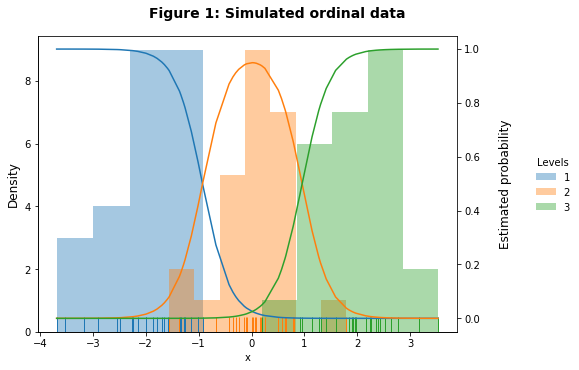

In [3]:
# Function to map prob over histogram
def dens_mapper(*args ,**kwargs):
    ax = plt.gca()
    frame = kwargs.pop('data')
    sns.distplot(a=frame['x'].values, hist=True, kde=False, rug=True, ax=ax, **kwargs)
    if frame.lvl.unique()=='lvls'+str(len(mus_1d)):
        ax2 = ax.twinx()
        sns.lineplot(data=df_1d_prob, x='x', y='prob',hue='lvl', legend=False, ax=ax2, **kwargs)
        ax2.set_ylabel('Estimated probability',size=12)
        ax2.yaxis.set_label_coords(1.1, 0.5)

g_1d = sns.FacetGrid(df_1d.sort_values('lvl'),hue='lvl',height=5,aspect=1.5,sharey=False)
g_1d.map_dataframe(dens_mapper)
g_1d.add_legend()
g_1d.fig.suptitle('Figure 1: Simulated ordinal data',size=14,weight='bold')
g_1d._legend.set_title('Levels')
g_1d.fig.subplots_adjust(top=0.9,right=0.8,left=0.1)
[z.set_text(t) for z,t in zip(g_1d._legend.texts,
                pd.Series(list(di_mu_1d.values())).astype(str).str.replace('lvls',''))]
g_1d.set_ylabels('Density',size=12)
g_1d.set_xlabels('x')

Figure 1 shows the distribution of x, the the density of the different classes represented by a colored histogram and the underlying marginal probabilities learned from $\hat\theta_1, \hat\theta_2$, and $\hat\beta$. The predicted marginal probabilites align nicely wit the true underlying densities showing that appropriate slope and intercept thresholds have been learned.

## 2-D example

To further build intuition, an ordinal Gaussian mixture model where $p=2$ and $K=4$ can be generated with four increasing centroids. The code block below will generate the data, git the model using `ordinal_reg` and then plot the two-dimensional decision boundaries. 

Predicted   1   2   3   4
Actual                   
lvls1      46   4   0   0
lvls2       1  41   8   0
lvls3       0   7  37   6
lvls4       0   0   7  43


Text(0.5, 0.98, 'Figure 2: Simulated 2D ordinal data')

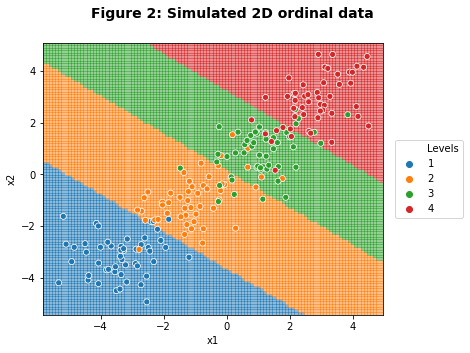

In [4]:
np.random.seed(1234)
cov = np.array([[1,0.5],[0.5,1]])
mus_2d = np.arange(-3,3+1,2)
df_2d = pd.concat([pd.DataFrame(np.random.multivariate_normal(np.array([mu,mu]),cov,n),
                                columns={'x1','x2'}).assign(mu=mu) for mu in mus_2d])
di_mu_2d = dict(zip(mus_2d,['lvls'+str(x+1) for x in range(len(mus_2d))]))
df_2d['lvl'] = df_2d.mu.map(di_mu_2d)
# Fit model
mdl_2d = ordinal_reg()
mdl_2d.fit(df_2d[['x1','x2']],df_2d.mu)
# Get accuracy
df_2d_acc = pd.crosstab(index=df_2d.lvl,columns=mdl_2d.predict(df_2d[['x1','x2']]))
df_2d_acc.index.name='Actual'
df_2d_acc.columns.name='Predicted'
print(df_2d_acc)
# Plot decision boundaries
x1, x2 = np.meshgrid(np.arange(df_2d.x1.min()-0.5, df_2d.x1.max()+0.5,0.1),
            np.arange(df_2d.x2.min()-0.5, df_2d.x2.max()+0.5,0.1))
yhat_2d = mdl_2d.predict(np.c_[x1.ravel(), x2.ravel()]).reshape(x1.shape)


fig, ax = plt.subplots(1, figsize=(7, 5))
plt.pcolormesh(x1, x2, yhat_2d, cmap=colors.ListedColormap(sns.color_palette(n_colors=4)), alpha=0.5)
sns.scatterplot('x1','x2','lvl',data=df_2d, ax=ax)
fig.axes[0].legend(loc='right',bbox_to_anchor=(1.25,0.5))
fig.subplots_adjust(right=0.8)
[z.set_text(t) for z,t in zip(fig.axes[0].legend_.texts[1:],
                pd.Series(list(di_mu_2d.values())).astype(str).str.replace('lvls',''))]
fig.axes[0].legend_.get_texts()[0].set_text('Levels')
fig.suptitle('Figure 2: Simulated 2D ordinal data',size=14,weight='bold')


As Figure 2 shows, the ordinal regresion model has once again calculated reasonable slope and intercept coefficients such that the model's decision boundaries align with our intuition of the underlying data distribution.

## Applied example for housing quantiles

While it is difficult to visualize the decision boundaries for datasets with $p>2$, an examination of the coefficients and performance of a model can indicate whether it is working well. To compare how ordinal regression fares to more common methods, housing prices from the [Boston housing](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html) dataset will be converted in different quantiles (bottom 10-20%, top 90+%, etc). The ordinal approach will be compared to a simple linear regression model where each quantile is treated as an integer ($y=[1,2,\dots,10]$) and a multinomial logistic regression where each class is treated as independently. To assess performance, the [mean-absolute error](https://en.wikipedia.org/wiki/Mean_absolute_error) (MAE) between the predicted and actual class will be used. For ordinal regression tasks, a metric like raw accuracy is less appealing as predicting 1 or 10 when $y=2$ receives the same score, when clearly predicting a quantile closer to the ground-truth level is more "accurate" even if it is not perfect. In the simulations below, a training/test split of 80/20% is used and run 125 times. Note that the house price label has added noise to it to ensure that quantiles can be calculated more smoothly.

In [5]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

X, y = load_boston(True)
y = np.log(y)
np.random.seed(1234)
y = y + np.random.randn(len(y))*(0.2*y.std())

nq = 10
thresholds = np.append(np.append(y.min()-1,np.quantile(y,np.arange(0,1,1/nq)[1:])),y.max()+1)
yq = pd.cut(x=y,bins=thresholds,right=True,labels=['q'+str(z+1) for z in range(nq)])
yord = yq.astype('category').codes+1

np.seterr(divide='ignore', invalid='ignore')
holder = []
nsim = 125
for ii in range(nsim):
  # Do a train/test split (80/20)
  ytrain, ytest, Xtrain, Xtest = train_test_split(yord, X, stratify=yord,test_size=0.2,random_state=ii)
  # Ordinal regression model
  mdl_ord = ordinal_reg()
  mdl_ord.fit(Xtrain, ytrain)
  # Linear regression
  mdl_linreg = LinearRegression().fit(Xtrain, ytrain)
  # Multinomial regression
  mdl_multi = LogisticRegression(penalty='none',solver='lbfgs',max_iter=1000)
  mdl_multi.fit(mdl_ord.Xenc.transform(Xtrain),ytrain)
  # Make predictions
  yhat_linreg = np.round(mdl_linreg.predict(Xtest)).astype(int)
  yhat_multi = mdl_multi.predict(mdl_ord.Xenc.transform(Xtest))
  yhat_ord = mdl_ord.predict(data=pd.DataFrame(Xtest))
  # Get accuracy
  acc_linreg = np.abs(yhat_linreg - ytest).mean()
  acc_multi = np.abs(yhat_multi == ytest).mean()
  acc_ord = np.abs(yhat_ord == ytest).mean()
  holder.append(pd.DataFrame({'ord':acc_ord,'multi':acc_multi,'linreg':acc_linreg},index=[ii]))

df_mae = pd.concat(holder).mean(axis=0).reset_index().rename(columns={'index':'mdl',0:'MAE'})
di_lbls = {'ord':'Ordinal','multi':'Multinomial','linreg':'Linear Regression'}
df_mae = df_mae.assign(mdl=lambda x: x.mdl.map(di_lbls))
print(np.round(df_mae,1))

                 mdl  MAE
0            Ordinal  0.2
1        Multinomial  0.4
2  Linear Regression  1.1


The table above shows that, on average, the ordinal regression model is only off by 0.2 of a quantile whereas the multinomial model is off by 0.4 and the least-squares model is off by a whole level. Interestingly the raw accuracy of the ordinal and multinomial model is virtually identical in these simulations. However because the loss function does not penalize the mutlinomial model for being significantly off as opposed to just modestly off, it is more likely to make larger errors. Figure 3 shows that the ordinal regression model outperforms both the multinomial and linear regression model in for every simulation iteration in terms of MAE.

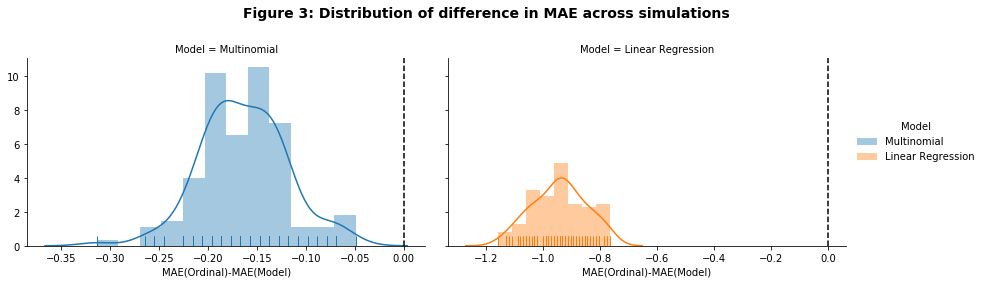

In [6]:
df_diff = pd.concat(holder).melt('ord').assign(d_ord = lambda x: x.ord - x.value).rename(columns={'variable':'Model'})
df_diff = df_diff.assign(Model = lambda x: x.Model.map(di_lbls))
g = sns.FacetGrid(df_diff,hue='Model',col='Model',height=4,aspect=1.5,sharex=False)
g.map(sns.distplot,'d_ord',rug=True)
for ax in g.axes.flat:
  ax.axvline(x=0,linestyle='--',c='black')
g.add_legend()
g.fig.suptitle(t='Figure 3: Distribution of difference in MAE across simulations',size=14,weight='bold')
g.fig.subplots_adjust(top=0.8)
g.set_xlabels('MAE(Ordinal)-MAE(Model)')

This post has shown how to write an optimizer to solve an ordinal regression model using a threshold approach which has $K-1$ intercepts (or thresholds) that ensure a positively increasing CDF to estimate the underlying ordinal labels. For outcomes where there is a natural and increasing order (like quantiles or ratings) the ordinal approach is well suited due to its easy interpretability. Most importantly, the ordinal loss function that encourages predicted labels to be *closer* to the actual label thereby reducing the likelihood of making large prediction errors (predicting 'high' instead of 'medium' when the actual label is 'low').